#Install and Import Libraries

In [1]:
!pip install -q torch transformers accelerate einops optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 11.6 MB/s eta 0:00:00


In [2]:
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

In [3]:
import random, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error

In [4]:
import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader

In [5]:
import math, time
from transformers import PatchTSTConfig, PatchTSTForPrediction, PatchTSTForRegression
import torch.nn.functional as F

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [7]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#Load dataset

In [20]:
dataset = pd.read_csv("dataset_ACB_fullFeatures.csv")
dataset['date'] = pd.to_datetime(dataset['date'])
dataset.set_index('date', inplace=True)

In [21]:
dataset.drop(columns=['ticker', 'field'], inplace=True)

In [22]:
dataset.head()

,open,high,low,close,volume,RSI_14,MA_10,MA_50,MA_200,MACD,MACD_SIGNAL,MACD_HIST,ADX_14,STOCH_K,STOCH_D,STOCHRSI_14,GDP × 10^9 (USD),CPI,usd_vnd
date,,,,,,,,,,,,,,,,,,,
2020-01-02,11224.6,11323.1,11175.4,11323.1,2360000.0,50.370623,11195.08,11560.370,11299.0160,-80.180196,-107.764083,27.583887,25.819285,72.218461,49.226332,84.562094,334.37,0.0523,23168.0
2020-01-03,11323.1,11421.5,11273.8,11323.1,2140000.0,50.370623,11219.70,11554.462,11298.0695,-66.727752,-99.556817,32.829065,24.032942,79.366845,55.047986,96.086247,334.37,0.0523,23171.0
2020-01-06,11323.1,11323.1,11076.9,11076.9,2610000.0,40.306248,11209.85,11543.630,11295.7025,-75.067543,-94.658962,19.591419,23.561703,57.148385,58.245687,76.499477,334.37,0.0523,23176.0
2020-01-07,11076.9,11175.4,11076.9,11076.9,2130000.0,40.306248,11195.08,11531.814,11294.0930,-80.746097,-91.876389,11.130292,23.124125,23.815051,54.961906,52.998953,334.37,0.0523,23175.0
2020-01-08,11076.9,11076.9,10830.8,10880.0,4680000.0,34.004354,11165.54,11516.060,11291.1200,-99.982045,-93.497520,-6.484525,23.870570,2.776367,48.479484,19.665620,334.37,0.0523,23175.0


In [23]:
numeric_vars = ['open', 'high', 'low','close','volume','RSI_14',
                'MA_10', 'MA_50', 'MA_200','MACD','MACD_SIGNAL','MACD_HIST',
                'ADX_14','STOCH_K','STOCH_D',
                'GDP × 10^9 (USD)', 'CPI', 'usd_vnd']
for var in numeric_vars:
  dataset[var] = pd.to_numeric(dataset[var], errors='coerce')

In [24]:
dataset.shape, dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1442 entries, 2020-01-02 to 2025-10-20
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   open              1442 non-null   float64
 1   high              1442 non-null   float64
 2   low               1442 non-null   float64
 3   close             1442 non-null   float64
 4   volume            1442 non-null   float64
 5   RSI_14            1442 non-null   float64
 6   MA_10             1442 non-null   float64
 7   MA_50             1442 non-null   float64
 8   MA_200            1442 non-null   float64
 9   MACD              1442 non-null   float64
 10  MACD_SIGNAL       1442 non-null   float64
 11  MACD_HIST         1442 non-null   float64
 12  ADX_14            1442 non-null   float64
 13  STOCH_K           1442 non-null   float64
 14  STOCH_D           1442 non-null   float64
 15  STOCHRSI_14       1442 non-null   float64
 16  GDP × 10^9 (USD)  1442 n

((1442, 19), None)

In [25]:
dataset.head()

,open,high,low,close,volume,RSI_14,MA_10,MA_50,MA_200,MACD,MACD_SIGNAL,MACD_HIST,ADX_14,STOCH_K,STOCH_D,STOCHRSI_14,GDP × 10^9 (USD),CPI,usd_vnd
date,,,,,,,,,,,,,,,,,,,
2020-01-02,11224.6,11323.1,11175.4,11323.1,2360000.0,50.370623,11195.08,11560.370,11299.0160,-80.180196,-107.764083,27.583887,25.819285,72.218461,49.226332,84.562094,334.37,0.0523,23168.0
2020-01-03,11323.1,11421.5,11273.8,11323.1,2140000.0,50.370623,11219.70,11554.462,11298.0695,-66.727752,-99.556817,32.829065,24.032942,79.366845,55.047986,96.086247,334.37,0.0523,23171.0
2020-01-06,11323.1,11323.1,11076.9,11076.9,2610000.0,40.306248,11209.85,11543.630,11295.7025,-75.067543,-94.658962,19.591419,23.561703,57.148385,58.245687,76.499477,334.37,0.0523,23176.0
2020-01-07,11076.9,11175.4,11076.9,11076.9,2130000.0,40.306248,11195.08,11531.814,11294.0930,-80.746097,-91.876389,11.130292,23.124125,23.815051,54.961906,52.998953,334.37,0.0523,23175.0
2020-01-08,11076.9,11076.9,10830.8,10880.0,4680000.0,34.004354,11165.54,11516.060,11291.1200,-99.982045,-93.497520,-6.484525,23.870570,2.776367,48.479484,19.665620,334.37,0.0523,23175.0


#Train / Valid/ Test Split and Preprocess

In [26]:
data = dataset.copy()

# Lưu data gốc TRƯỚC KHI SCALE
data_original = data.copy()

train_ratio = 0.6
valid_ratio = 0.15

n = len(data)
train_end = int(train_ratio * n)
valid_end = int((train_ratio + valid_ratio) * n)

train_df = data.iloc[:train_end].copy()
valid_df = data.iloc[train_end:valid_end].copy()
test_df  = data.iloc[valid_end:].copy()

# Data gốc cho evaluation
train_df_original = data_original.iloc[:train_end].copy()
valid_df_original = data_original.iloc[train_end:valid_end].copy()
test_df_original  = data_original.iloc[valid_end:].copy()

print(f"Total: {n}")
print(f"Train: {len(train_df)}, Valid: {len(valid_df)}, Test: {len(test_df)}")

Total: 1442
Train: 865, Valid: 216, Test: 361


In [27]:
# Features dùng RobustScaler (KHÔNG bao gồm close)
features_robust = ['open', 'high', 'low','volume','RSI_14',
                'MA_10', 'MA_50', 'MA_200','MACD','MACD_SIGNAL','MACD_HIST',
                'ADX_14','STOCH_K','STOCH_D','STOCHRSI_14',
                'GDP × 10^9 (USD)', 'CPI', 'usd_vnd']

# RobustScaler cho các features khác
scaler_robust = RobustScaler().fit(train_df[features_robust])

train_df[features_robust] = scaler_robust.transform(train_df[features_robust])
valid_df[features_robust] = scaler_robust.transform(valid_df[features_robust])
test_df[features_robust]  = scaler_robust.transform(test_df[features_robust])

#StandardScaler cho close
scaler_close = StandardScaler().fit(train_df[['close']])

train_df['close'] = scaler_close.transform(train_df[['close']])
valid_df['close'] = scaler_close.transform(valid_df[['close']])
test_df['close']  = scaler_close.transform(test_df[['close']])

#KHÔNG scale pct_change - giữ nguyên
print(f"\nScaling summary:")
print(f"  RobustScaler: {features_robust}")
print(f"  StandardScaler: ['close']")


Scaling summary:
  RobustScaler: ['open', 'high', 'low', 'volume', 'RSI_14', 'MA_10', 'MA_50', 'MA_200', 'MACD', 'MACD_SIGNAL', 'MACD_HIST', 'ADX_14', 'STOCH_K', 'STOCH_D', 'STOCHRSI_14', 'GDP × 10^9 (USD)', 'CPI', 'usd_vnd']
  StandardScaler: ['close']


#Dataset, DataLoader

In [28]:
class StockDataset(Dataset):
    def __init__(self, df, df_original, feature_cols, horizons=[1, 4, 8, 12, 24], window=36):
        """
        Args:
            df: DataFrame đã được scale
            df_original: DataFrame GỐC (chưa scale) để lấy giá thực
            feature_cols: Các cột feature (bao gồm pct_change)
            horizons: Các horizon cần dự đoán
            window: Số ngày lookback (L)
        """
        self.samples = []
        self.horizons = horizons

        features = df[feature_cols].values
        close_original = df_original['close'].values  # Giá GỐC chưa scale

        n = len(df)
        for i in range(n - window - max(horizons)):
            X = features[i : i + window]

            # Base price GỐC (ngày cuối window)
            base_price = close_original[i + window - 1]

            # Target: cumulative pct_change từ ngày L đến ngày L+H
            y = []
            actual_prices = []
            for h in horizons:
                future_price = close_original[i + window + h - 1]
                cumulative_return = (future_price - base_price) / base_price if base_price != 0 else 0
                y.append(cumulative_return)
                actual_prices.append(future_price)

            self.samples.append((X, y, base_price, actual_prices))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        X, y, base_price, actual_prices = self.samples[idx]
        return (torch.tensor(X, dtype=torch.float32),
                torch.tensor(y, dtype=torch.float32),
                torch.tensor(base_price, dtype=torch.float32),
                torch.tensor(actual_prices, dtype=torch.float32))

#Early Stopping

In [29]:
# Early Stopping
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.0001):
        self.patience = patience
        self.min_delta = min_delta
        self.best = None
        self.count = 0
        self.best_state = None

    def step(self, metric, model):
        improved = (self.best is None) or (metric < self.best - self.min_delta)
        if improved:
            self.best = metric
            self.count = 0
            self.best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.count += 1
        return improved, self.count >= self.patience

#Optimize HyperParameters

In [30]:
# Cấu hình
H_LIST = [1, 4, 7, 10, 14, 21]  # Horizons cần dự đoán

In [31]:
feature_cols = features_robust + ['close']
print(f"\nFeature columns ({len(feature_cols)}): {feature_cols}")


Feature columns (19): ['open', 'high', 'low', 'volume', 'RSI_14', 'MA_10', 'MA_50', 'MA_200', 'MACD', 'MACD_SIGNAL', 'MACD_HIST', 'ADX_14', 'STOCH_K', 'STOCH_D', 'STOCHRSI_14', 'GDP × 10^9 (USD)', 'CPI', 'usd_vnd', 'close']


In [32]:
best_L = None
best_valid_loss = float('inf')
best_model_state = None
results_by_L = {}

In [33]:
def objective(trial):
    # === HYPERPARAMETERS CẦN TỐI ƯU ===
    L = trial.suggest_categorical('L', [12, 24, 36, 48, 60, 72, 84, 96])
    patch_len = trial.suggest_categorical('patch_len', [4, 8, 12, 16])
    stride = trial.suggest_categorical('stride', [2, 4, 6, 8])
    d_model = trial.suggest_categorical('d_model', [32, 64, 128, 256])
    n_heads = trial.suggest_categorical('n_heads', [2, 4, 8])
    num_encoder_layers = trial.suggest_int('num_encoder_layers', 1, 4)
    dropout = trial.suggest_float('dropout', 0.1, 0.5, step=0.1)

    # === RÀNG BUỘC ===
    # 1. d_model phải chia hết cho n_heads
    if d_model % n_heads != 0:
        raise optuna.TrialPruned()

    # 2. patch_len phải <= L
    if patch_len > L:
        raise optuna.TrialPruned()

    # 3. stride phải <= patch_len
    if stride > patch_len:
        raise optuna.TrialPruned()

    # 4. Số patches phải >= 1
    num_patches = (L - patch_len) // stride + 1
    if num_patches < 1:
        raise optuna.TrialPruned()

    # === TẠO DATASET ===
    train_dataset = StockDataset(train_df, train_df_original, feature_cols, horizons=H_LIST, window=L)
    valid_dataset = StockDataset(valid_df, valid_df_original, feature_cols, horizons=H_LIST, window=L)

    if len(train_dataset) < 10 or len(valid_dataset) < 5:
        raise optuna.TrialPruned()

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

    # === TẠO MODEL ===
    num_features = len(feature_cols)

    config = PatchTSTConfig(
        num_input_channels=num_features,
        context_length=L,
        patch_len=patch_len,
        stride=stride,
        d_model=d_model,
        n_heads=n_heads,
        num_encoder_layers=num_encoder_layers,
        dropout=dropout,
        num_targets=len(H_LIST),
    )

    model = PatchTSTForRegression(config).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    early_stopping = EarlyStopping(patience=7, min_delta=1e-5)

    # === TRAINING LOOP ===
    for epoch in range(1, 51):
        model.train()
        for X_batch, y_batch, _, _ in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            out = model(past_values=X_batch)
            loss = criterion(out.regression_outputs, y_batch)
            loss.backward()
            clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch, _, _ in valid_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                out = model(past_values=X_batch)
                val_loss += criterion(out.regression_outputs, y_batch).item()
        val_loss /= len(valid_loader)

        # Pruning
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

        improved, should_stop = early_stopping.step(val_loss, model)
        if should_stop:
            break

    return early_stopping.best

In [34]:
study = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_startup_trials=10, n_warmup_steps=5)
)

study.optimize(objective, n_trials=50, show_progress_bar=True)

# Kết quả
print(f"\n{'='*50}")
print(f"BEST PARAMS:")
print(f"  L: {study.best_params['L']}")
print(f"  patch_len: {study.best_params['patch_len']}")
print(f"  stride: {study.best_params['stride']}")
print(f"  d_model: {study.best_params['d_model']}")
print(f"  n_heads: {study.best_params['n_heads']}")
print(f"  num_encoder_layers: {study.best_params['num_encoder_layers']}")
print(f"  dropout: {study.best_params['dropout']}")
print(f"  Valid Loss: {study.best_value:.6f}")

[I 2025-12-16 12:26:14,326] A new study created in memory with name: no-name-06447b91-0cfc-480e-b86c-d2ea94b6dfec


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-16 12:26:22,304] Trial 0 finished with value: 0.0014727027349484463 and parameters: {'L': 24, 'patch_len': 16, 'stride': 2, 'd_model': 64, 'n_heads': 2, 'num_encoder_layers': 2, 'dropout': 0.30000000000000004}. Best is trial 0 with value: 0.0014727027349484463.
[I 2025-12-16 12:26:28,784] Trial 1 finished with value: 0.0015422135669117172 and parameters: {'L': 12, 'patch_len': 8, 'stride': 4, 'd_model': 128, 'n_heads': 2, 'num_encoder_layers': 3, 'dropout': 0.1}. Best is trial 0 with value: 0.0014727027349484463.
[I 2025-12-16 12:26:38,183] Trial 2 finished with value: 0.0015931304272574682 and parameters: {'L': 12, 'patch_len': 12, 'stride': 2, 'd_model': 256, 'n_heads': 2, 'num_encoder_layers': 4, 'dropout': 0.4}. Best is trial 0 with value: 0.0014727027349484463.
[I 2025-12-16 12:27:28,191] Trial 3 finished with value: 0.0026207934715785086 and parameters: {'L': 72, 'patch_len': 16, 'stride': 4, 'd_model': 256, 'n_heads': 4, 'num_encoder_layers': 1, 'dropout': 0.1}. Best 

#Training With PatchTST

In [35]:
# === SỬ DỤNG BEST PARAMS TỪ OPTUNA (trừ L) ===
best_patch_len = study.best_params['patch_len']
best_stride = study.best_params['stride']
best_d_model = study.best_params['d_model']
best_n_heads = study.best_params['n_heads']
best_num_encoder_layers = study.best_params['num_encoder_layers']
best_dropout = study.best_params['dropout']

print(f"Using Optuna best params:")
print(f"  patch_len={best_patch_len}, stride={best_stride}")
print(f"  d_model={best_d_model}, n_heads={best_n_heads}")
print(f"  num_encoder_layers={best_num_encoder_layers}, dropout={best_dropout}")

Using Optuna best params:
  patch_len=16, stride=8
  d_model=32, n_heads=8
  num_encoder_layers=2, dropout=0.4


In [36]:
# Cấu hình
L_VALUES = [12, 24, 36, 48, 60, 72, 84, 96]  # Context length (window size) - PatchTST thường cần L lớn hơn
H_LIST = [1, 4, 7, 10, 14, 21]  # Horizons cần dự đoán

In [37]:
feature_cols = features_robust + ['close']
print(f"\nFeature columns ({len(feature_cols)}): {feature_cols}")


Feature columns (19): ['open', 'high', 'low', 'volume', 'RSI_14', 'MA_10', 'MA_50', 'MA_200', 'MACD', 'MACD_SIGNAL', 'MACD_HIST', 'ADX_14', 'STOCH_K', 'STOCH_D', 'STOCHRSI_14', 'GDP × 10^9 (USD)', 'CPI', 'usd_vnd', 'close']


In [38]:
best_L = None
best_valid_loss = float('inf')
best_model_state = None
results_by_L = {}

In [39]:
for L in L_VALUES:
    print(f"\n{'='*60}")
    print(f"TRAINING PatchTST WITH L = {L}")
    print(f"{'='*60}")

    # Kiểm tra ràng buộc: patch_len phải <= L
    if best_patch_len > L:
        print(f"Skipping L={L}: patch_len ({best_patch_len}) > L ({L})")
        continue

    # Tạo dataset
    train_dataset = StockDataset(train_df, train_df_original, feature_cols, horizons=H_LIST, window=L)
    valid_dataset = StockDataset(valid_df, valid_df_original, feature_cols, horizons=H_LIST, window=L)

    print(f"Train samples: {len(train_dataset)}, Valid samples: {len(valid_dataset)}")

    if len(train_dataset) < 10 or len(valid_dataset) < 5:
        print(f"Skipping L={L}: Not enough samples")
        continue

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

    # CẤU HÌNH PatchTSTForRegression với params từ Optuna
    num_features = len(feature_cols)

    config = PatchTSTConfig(
        num_input_channels=num_features,
        context_length=L,
        patch_len=best_patch_len,
        stride=best_stride,
        d_model=best_d_model,
        n_heads=best_n_heads,
        num_encoder_layers=best_num_encoder_layers,
        dropout=best_dropout,
        num_targets=len(H_LIST),
    )

    model = PatchTSTForRegression(config).to(device)
    print(f"PatchTST parameters: {model.num_parameters():,}")

    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )
    early_stopping = EarlyStopping(patience=7, min_delta=1e-5)

    EPOCHS = 50
    train_losses, valid_losses = [], []

    for epoch in range(1, EPOCHS + 1):
        # TRAINING
        model.train()
        running_train = 0.0
        for X_batch, y_batch, _, _ in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            out = model(past_values=X_batch)
            preds = out.regression_outputs

            loss = criterion(preds, y_batch)
            loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_train += loss.item() * X_batch.size(0)

        avg_train = running_train / len(train_dataset)
        train_losses.append(avg_train)

        # VALIDATION
        model.eval()
        running_valid = 0.0
        with torch.no_grad():
            for X_batch, y_batch, _, _ in valid_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                out = model(past_values=X_batch)
                preds = out.regression_outputs

                loss = criterion(preds, y_batch)
                running_valid += loss.item() * X_batch.size(0)

        avg_valid = running_valid / len(valid_dataset)
        valid_losses.append(avg_valid)

        scheduler.step(avg_valid)
        improved, stop = early_stopping.step(avg_valid, model)

        if epoch % 10 == 0 or improved:
            mark = "*" if improved else ""
            print(f"Epoch {epoch:3d} | Train: {avg_train:.6f} | Valid: {avg_valid:.6f} {mark}")

        if stop:
            print(f"Early stopping at epoch {epoch}")
            break

    final_valid_loss = early_stopping.best
    results_by_L[L] = {
        'valid_loss': final_valid_loss,
        'train_losses': train_losses,
        'valid_losses': valid_losses,
        'model_state': early_stopping.best_state,
        'patch_len': best_patch_len,
        'stride': best_stride
    }

    if final_valid_loss < best_valid_loss:
        best_valid_loss = final_valid_loss
        best_L = L
        best_model_state = early_stopping.best_state

    print(f"\nL={L} completed. Best valid loss: {final_valid_loss:.6f}")

print(f"\n{'='*60}")
print(f"BEST L = {best_L} with valid loss = {best_valid_loss:.6f}")
print(f"{'='*60}")


TRAINING PatchTST WITH L = 12
Skipping L=12: patch_len (16) > L (12)

TRAINING PatchTST WITH L = 24
Train samples: 820, Valid samples: 171
PatchTST parameters: 117,478
Epoch   1 | Train: 0.004700 | Valid: 0.001437 *
Epoch   3 | Train: 0.004146 | Valid: 0.001305 *
Epoch  10 | Train: 0.002550 | Valid: 0.003354 
Early stopping at epoch 10

L=24 completed. Best valid loss: 0.001305

TRAINING PatchTST WITH L = 36
Train samples: 808, Valid samples: 159
PatchTST parameters: 117,862
Epoch   1 | Train: 0.004632 | Valid: 0.001447 *
Epoch   3 | Train: 0.004026 | Valid: 0.001424 *
Epoch  10 | Train: 0.002266 | Valid: 0.002788 
Early stopping at epoch 10

L=36 completed. Best valid loss: 0.001424

TRAINING PatchTST WITH L = 48
Train samples: 796, Valid samples: 147
PatchTST parameters: 118,246
Epoch   1 | Train: 0.004254 | Valid: 0.001520 *
Early stopping at epoch 8

L=48 completed. Best valid loss: 0.001520

TRAINING PatchTST WITH L = 60
Train samples: 784, Valid samples: 135
PatchTST parameters:

#Plot Traning, Valid Loss

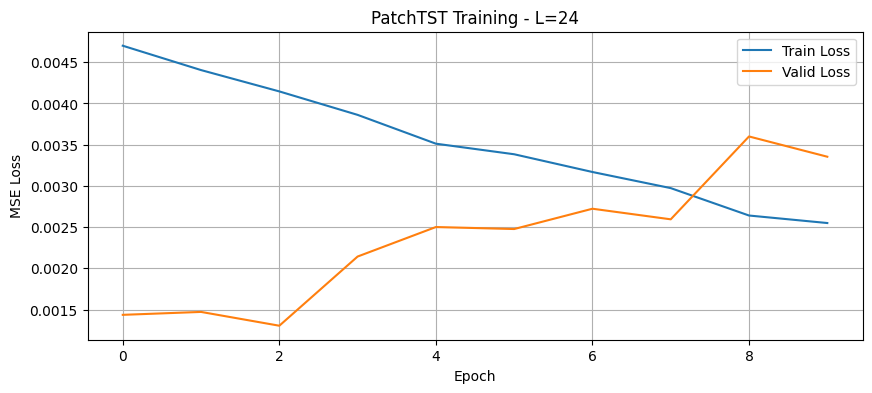

In [40]:
if best_L is not None:
    plt.figure(figsize=(10, 4))
    plt.plot(results_by_L[best_L]['train_losses'], label='Train Loss')
    plt.plot(results_by_L[best_L]['valid_losses'], label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title(f'PatchTST Training - L={best_L}')
    plt.legend()
    plt.grid(True)
    plt.show()

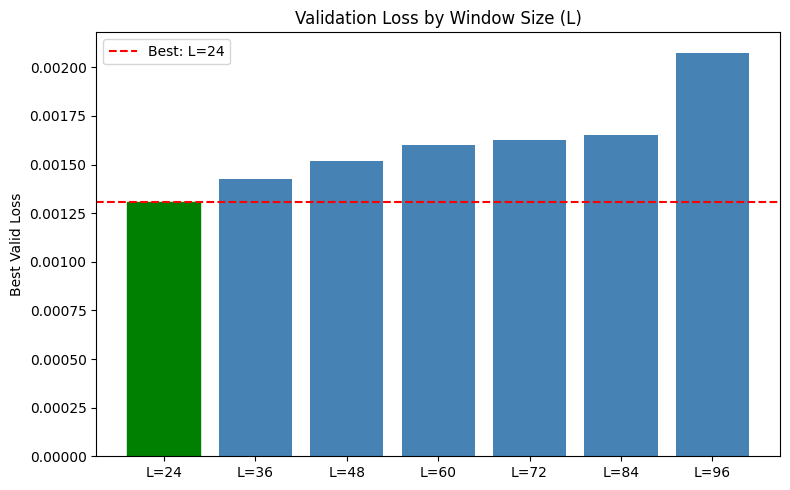


     L |   Valid Loss |   Rank
    24 |     0.001305 |      1 ← Best
    36 |     0.001424 |      2
    48 |     0.001520 |      3
    60 |     0.001603 |      4
    72 |     0.001627 |      5
    84 |     0.001652 |      6
    96 |     0.002076 |      7


In [41]:
plt.figure(figsize=(8, 5))

# So sánh valid loss các L
L_list = list(results_by_L.keys())
valid_losses_list = [results_by_L[L]['valid_loss'] for L in L_list]

bars = plt.bar(range(len(L_list)), valid_losses_list, color='steelblue')
plt.xticks(range(len(L_list)), [f'L={L}' for L in L_list])
plt.ylabel('Best Valid Loss')
plt.title('Validation Loss by Window Size (L)')
plt.axhline(y=best_valid_loss, color='red', linestyle='--', label=f'Best: L={best_L}')

# Highlight best L
best_idx = L_list.index(best_L)
bars[best_idx].set_color('green')
plt.legend()

plt.tight_layout()
plt.show()

# In bảng so sánh
print(f"\n{'='*40}")
print(f"{'L':>6} | {'Valid Loss':>12} | {'Rank':>6}")
print(f"{'='*40}")
sorted_results = sorted(results_by_L.items(), key=lambda x: x[1]['valid_loss'])
for rank, (L, res) in enumerate(sorted_results, 1):
    marker = " ← Best" if L == best_L else ""
    print(f"{L:>6} | {res['valid_loss']:>12.6f} | {rank:>6}{marker}")

#Evaluate on Test with Best L

In [42]:
print(f"\n{'='*60}")
print(f"EVALUATING ON TEST SET WITH BEST L = {best_L}")
print(f"{'='*60}")

# Tạo test dataset
test_dataset = StockDataset(
    test_df, test_df_original, feature_cols,
    horizons=H_LIST, window=best_L
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Test samples: {len(test_dataset)}")

# Lấy lại patch_len và stride từ results
patch_len = results_by_L[best_L]['patch_len']
stride = results_by_L[best_L]['stride']

# Tạo lại model - DÙNG PatchTSTForRegression
num_features = len(feature_cols)

config = PatchTSTConfig(
        num_input_channels=num_features,
        context_length=best_L,
        patch_len=best_patch_len,
        stride=best_stride,
        d_model=best_d_model,
        n_heads=best_n_heads,
        num_encoder_layers=best_num_encoder_layers,
        dropout=best_dropout,
        num_targets=len(H_LIST),
        )

model = PatchTSTForRegression(config).to(device)
model.load_state_dict(best_model_state)
model.eval()

# Thu thập predictions
all_preds = []
all_targets = []
all_base_prices = []
all_actual_prices = []

with torch.no_grad():
    for X_batch, y_batch, base_batch, actual_batch in test_loader:
        X_batch = X_batch.to(device)

        out = model(past_values=X_batch)
        preds = out.regression_outputs  # [batch, 5] - KHÔNG CẦN slice

        all_preds.append(preds.cpu().numpy())
        all_targets.append(y_batch.numpy())
        all_base_prices.append(base_batch.numpy())
        all_actual_prices.append(actual_batch.numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)
all_base_prices = np.concatenate(all_base_prices, axis=0)
all_actual_prices = np.concatenate(all_actual_prices, axis=0)

print(f"Predictions shape: {all_preds.shape}")
print(f"Targets shape: {all_targets.shape}")


EVALUATING ON TEST SET WITH BEST L = 24
Test samples: 316
Predictions shape: (316, 6)
Targets shape: (316, 6)


In [43]:
print("\n=== TEST SET RESULTS (ACTUAL PRICE - VND) ===")

# Chuyển cumulative return về giá: pred_price = base_price * (1 + cumulative_return)
pred_prices = np.zeros_like(all_preds)
for i in range(len(all_base_prices)):
    for j in range(len(H_LIST)):
        delta = all_base_prices[i] * all_preds[i, j]
        pred_prices[i, j] = all_base_prices[i] + delta

for i, h in enumerate(H_LIST):
    actual = all_actual_prices[:, i]
    pred   = pred_prices[:, i]

    # Mean price (dùng để scale về 0–1)
    mean_price = actual.mean()

    # Metrics gốc (VND)
    mae  = mean_absolute_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mape = np.mean(np.abs((actual - pred) / actual)) * 100
    r2   = r2_score(actual, pred)

    # Metrics normalized (0 → 1)
    mae_norm  = mae / mean_price
    rmse_norm = rmse / mean_price

    print(
        f"H={h:3d}: "
        f"MAE={mae:,.2f} VND | "
        f"RMSE={rmse:,.2f} VND | "
        f"MAE_norm={mae_norm:.5f} | "
        f"RMSE_norm={rmse_norm:.5f} | "
        f"MAPE={mape:.2f}% | "
        f"R2={r2:.5f}"
    )


=== TEST SET RESULTS (ACTUAL PRICE - VND) ===
H=  1: MAE=267.19 VND | RMSE=458.61 VND | MAE_norm=0.01089 | RMSE_norm=0.01869 | MAPE=1.09% | R2=0.91873
H=  4: MAE=563.12 VND | RMSE=863.76 VND | MAE_norm=0.02295 | RMSE_norm=0.03520 | MAPE=2.30% | R2=0.71283
H=  7: MAE=789.97 VND | RMSE=1,112.15 VND | MAE_norm=0.03218 | RMSE_norm=0.04530 | MAPE=3.24% | R2=0.52581
H= 10: MAE=912.03 VND | RMSE=1,263.95 VND | MAE_norm=0.03712 | RMSE_norm=0.05145 | MAPE=3.74% | R2=0.38975
H= 14: MAE=1,211.98 VND | RMSE=1,589.52 VND | MAE_norm=0.04927 | RMSE_norm=0.06462 | MAPE=4.98% | R2=0.04939
H= 21: MAE=1,408.68 VND | RMSE=1,928.68 VND | MAE_norm=0.05715 | RMSE_norm=0.07825 | MAPE=5.83% | R2=-0.36112


#Visualize Predictions

In [44]:
print("\n" + "="*70)
print("SAMPLE PREDICTIONS (Last 5 samples)")
print("="*70)

for sample_idx in range(-5, 0):
    base = all_base_prices[sample_idx]
    print(f"\n📊 Sample {sample_idx}: Base Price = {base:,.0f} VND")
    print("-" * 60)

    for i, h in enumerate(H_LIST):
        actual_price = all_actual_prices[sample_idx, i]
        pred_pct = all_preds[sample_idx, i]  # Đổi all_y_pred → all_preds

        # Tính giá dự đoán: base + (base * cumulative_return)
        delta = base * pred_pct
        pred_price = base + delta

        error = abs(actual_price - pred_price)
        error_pct = error / actual_price * 100

        direction = "📈" if pred_pct > 0 else "📉"

        print(f"  H={h:3d}: cumulative_return={pred_pct:+.4f} ({pred_pct*100:+.2f}%) {direction}")
        print(f"         Delta={delta:+,.0f} VND")
        print(f"         Actual={actual_price:>10,.0f} VND | Pred={pred_price:>10,.0f} VND | Error={error:>8,.0f} VND ({error_pct:.2f}%)")


SAMPLE PREDICTIONS (Last 5 samples)

📊 Sample -5: Base Price = 26,300 VND
------------------------------------------------------------
  H=  1: cumulative_return=-0.0000 (-0.00%) 📉
         Delta=-1 VND
         Actual=    26,400 VND | Pred=    26,299 VND | Error=     101 VND (0.38%)
  H=  4: cumulative_return=-0.0011 (-0.11%) 📉
         Delta=-29 VND
         Actual=    25,550 VND | Pred=    26,271 VND | Error=     721 VND (2.82%)
  H=  7: cumulative_return=+0.0111 (+1.11%) 📈
         Delta=+293 VND
         Actual=    25,350 VND | Pred=    26,593 VND | Error=   1,243 VND (4.90%)
  H= 10: cumulative_return=+0.0052 (+0.52%) 📈
         Delta=+135 VND
         Actual=    25,650 VND | Pred=    26,435 VND | Error=     785 VND (3.06%)
  H= 14: cumulative_return=+0.0259 (+2.59%) 📈
         Delta=+682 VND
         Actual=    25,750 VND | Pred=    26,982 VND | Error=   1,232 VND (4.78%)
  H= 21: cumulative_return=+0.0210 (+2.10%) 📈
         Delta=+553 VND
         Actual=    26,750 VND | Pred

pred_prices shape: (316, 6)
all_actual_prices shape: (316, 6)


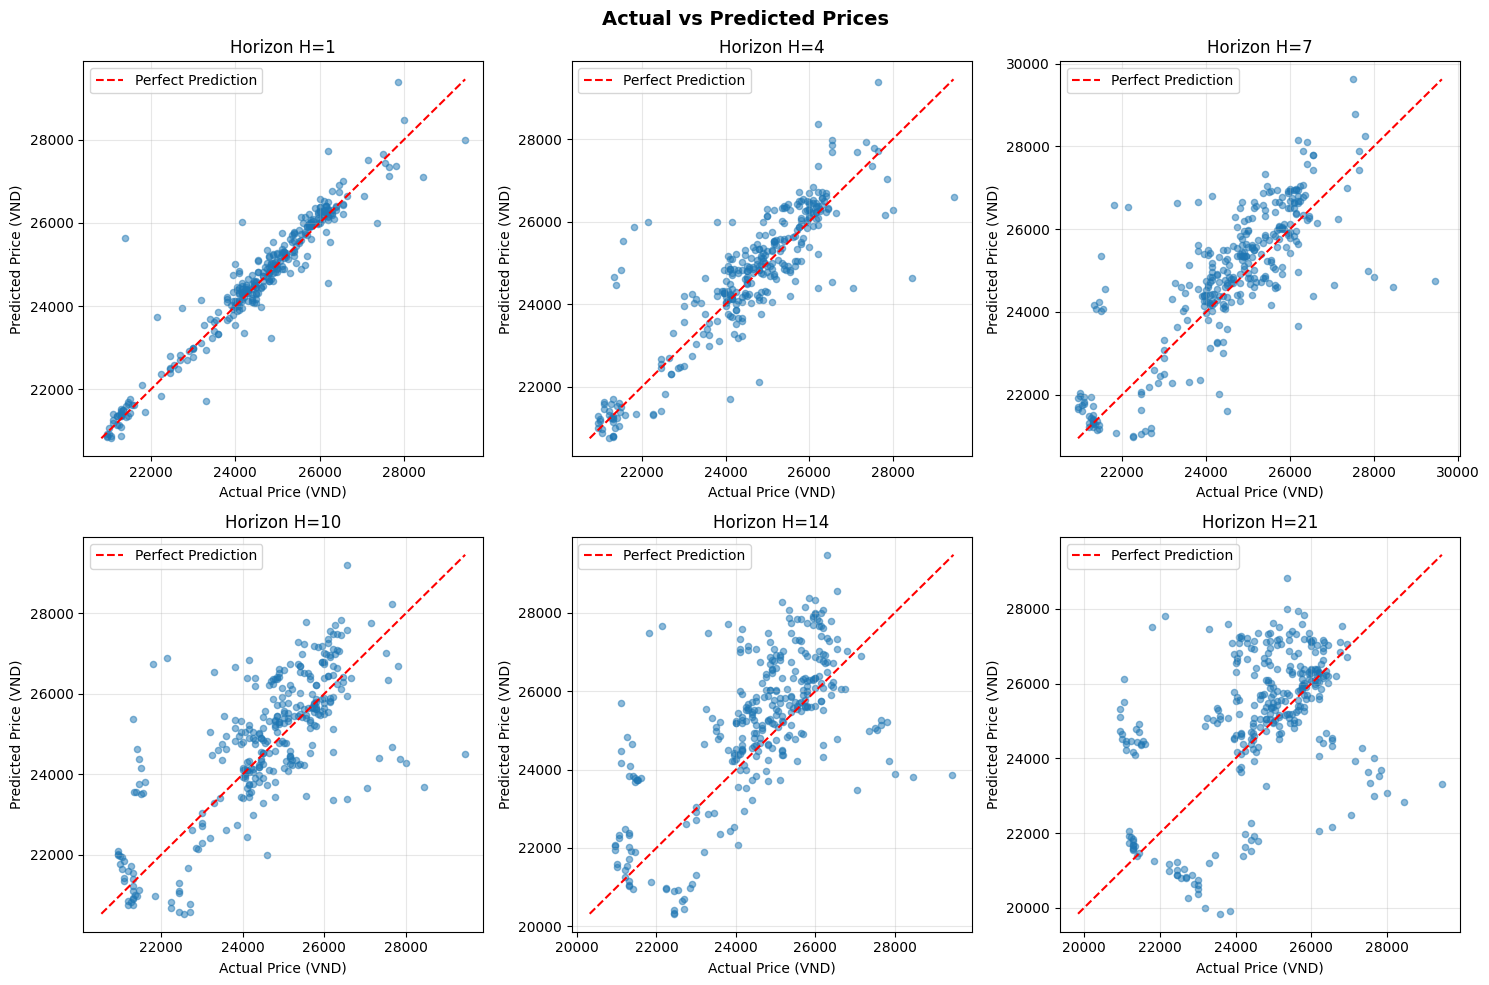

In [45]:
# Tính pred_prices trước khi plot
pred_prices = np.zeros_like(all_preds)  # [N, 5]
for i in range(len(all_base_prices)):
    for j in range(len(H_LIST)):
        delta = all_base_prices[i] * all_preds[i, j]
        pred_prices[i, j] = all_base_prices[i] + delta

# Kiểm tra shape
print(f"pred_prices shape: {pred_prices.shape}")
print(f"all_actual_prices shape: {all_actual_prices.shape}")

# Plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, h in enumerate(H_LIST):
    if i >= len(axes):
        break

    actual = all_actual_prices[:, i]
    pred = pred_prices[:, i]

    axes[i].scatter(actual, pred, alpha=0.5, s=20)

    # Đường perfect prediction
    min_val = min(actual.min(), pred.min())
    max_val = max(actual.max(), pred.max())
    axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

    axes[i].set_xlabel('Actual Price (VND)')
    axes[i].set_ylabel('Predicted Price (VND)')
    axes[i].set_title(f'Horizon H={h}')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

# Ẩn subplot thừa
if len(H_LIST) < len(axes):
    axes[-1].axis('off')

plt.suptitle('Actual vs Predicted Prices', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

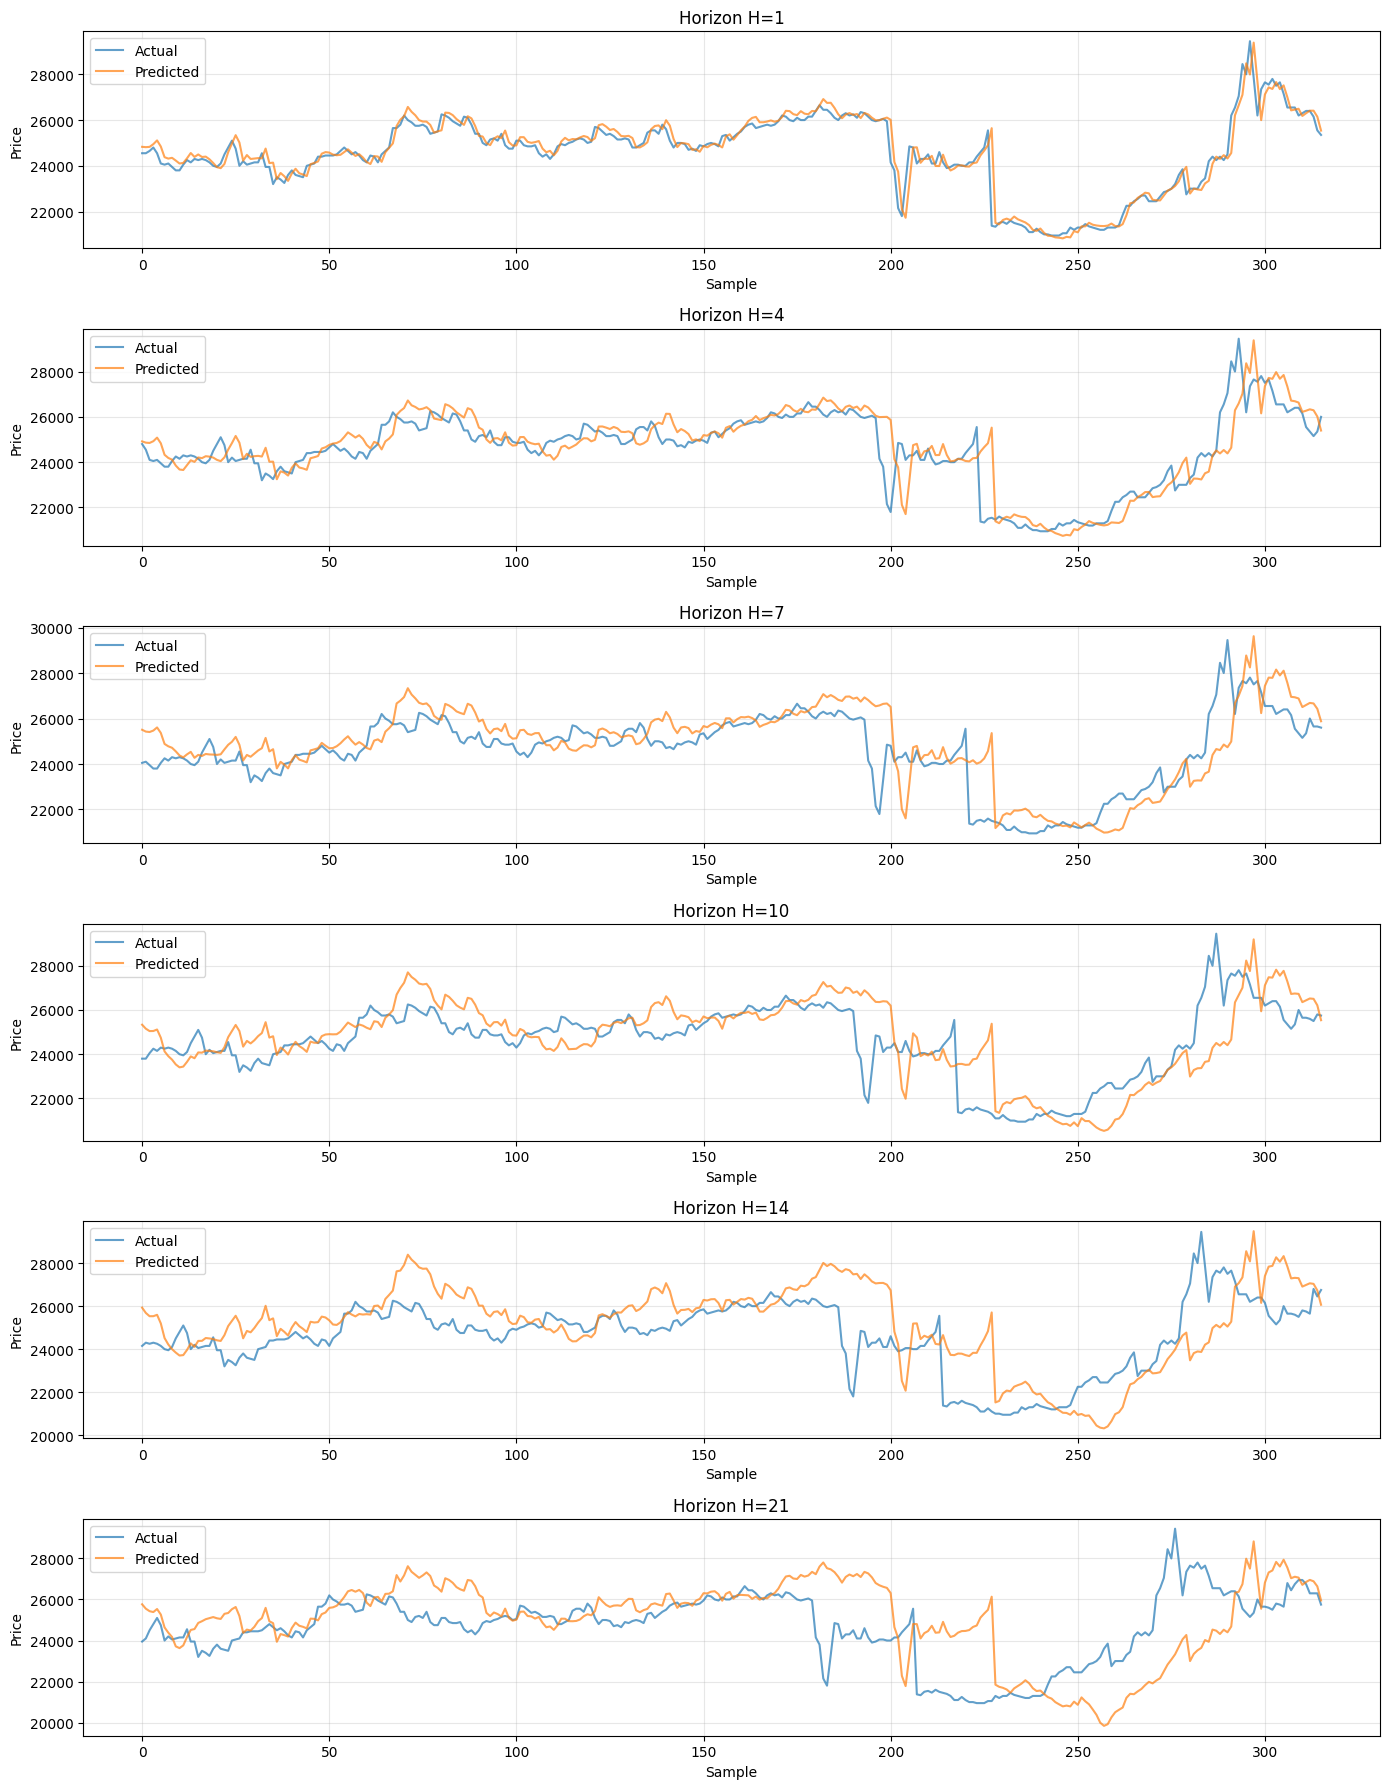

In [46]:
# Plot predictions vs actual cho một vài horizons
fig, axes = plt.subplots(len(H_LIST), 1, figsize=(14, 3*len(H_LIST)))

for i, h in enumerate(H_LIST):
    ax = axes[i] if len(H_LIST) > 1 else axes

    pred_prices = all_base_prices * (1 + all_preds[:, i])
    actual_prices = all_actual_prices[:, i]

    ax.plot(actual_prices, label='Actual', alpha=0.7)
    ax.plot(pred_prices, label='Predicted', alpha=0.7)
    ax.set_title(f'Horizon H={h}')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [47]:
torch.save({
    'model_state_dict': best_model_state,
    'best_L': best_L,
    'scaler_robust': scaler_robust,
    'scaler_close': scaler_close,
    'features_robust': features_robust,
    'feature_cols': feature_cols,
    'horizons': H_LIST,
    'model_type': 'PatchTSTForRegression',
    'config': {
        'num_input_channels': num_features,
        'context_length': best_L,
        'patch_len': patch_len,
        'stride': stride,
        'd_model': 128,
        'n_heads': 4,
        'num_encoder_layers': 2,
        'dropout': 0.3,
        'num_targets': len(H_LIST),
    }
}, f'patchtst_Fullfts_L{best_L}.pth')

print(f"\nModel saved as 'patchtst_Fullfts_L{best_L}.pth'")


Model saved as 'patchtst_Fullfts_L24.pth'
